<a href="https://colab.research.google.com/github/FiorenSt/SiSAD/blob/main/Tutorial_StampAD.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#STAMP AD Project

## The goal is to build a network for unsupervised (or semi-supervised) clustering and detection of anomalies and transients in ZTF stamps.

## To get started:

Step 0.
Click the link to access the google drive folder containing the images: https://drive.google.com/drive/folders/1EXLUv6MQas2m7U7FKBilfRLwRBf6qdyE?usp=drive_link

Step 1.
Right click on the folder. Under Organize, click Add Shortcut (Add it to your drive)

Step 2.
Mount your drive in Colab with the code below

In [ ]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [ ]:
h5_folder_path = '/content/drive/MyDrive/Time Domain Needles 2024 Data'

In [ ]:
import os

# Ensure the path is correct
assert os.path.exists(h5_folder_path), "The specified path does not exist. Please check the path to the shared folder."

# List the first few files in the directory
print("Contents of the folder:", os.listdir(h5_folder_path)[:5])

Contents of the folder: ['triplets_1.h5', 'triplets_2.h5', 'triplets_3.h5', 'triplets_4.h5', 'triplets_5.h5']


## Files description

Each h5 file contains 1000 triplets (new, reference, difference). To visualize some of the images, run the code below:

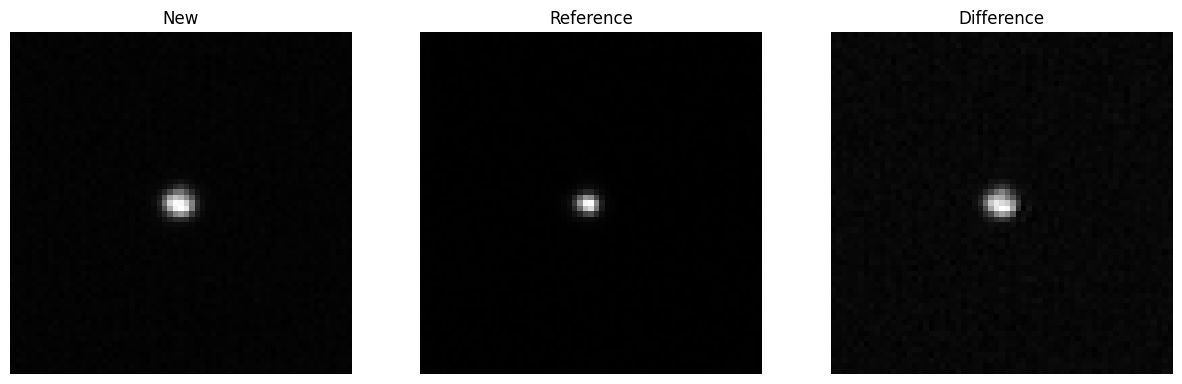

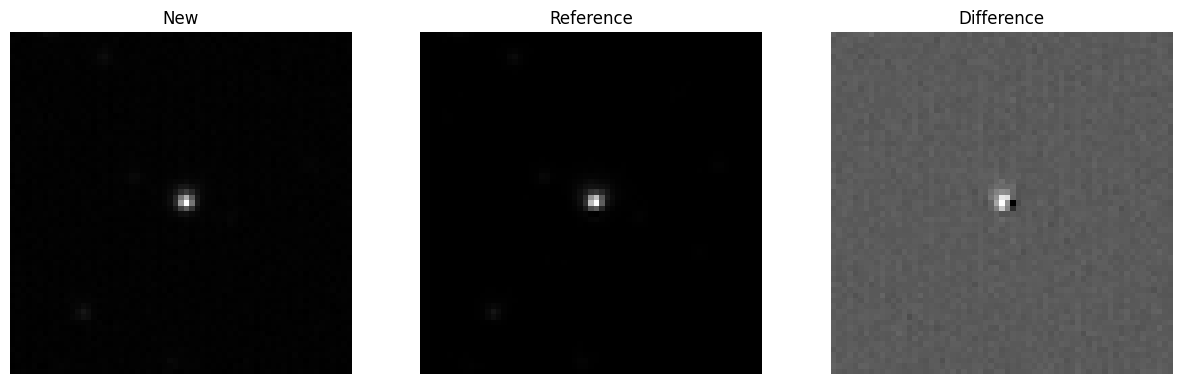

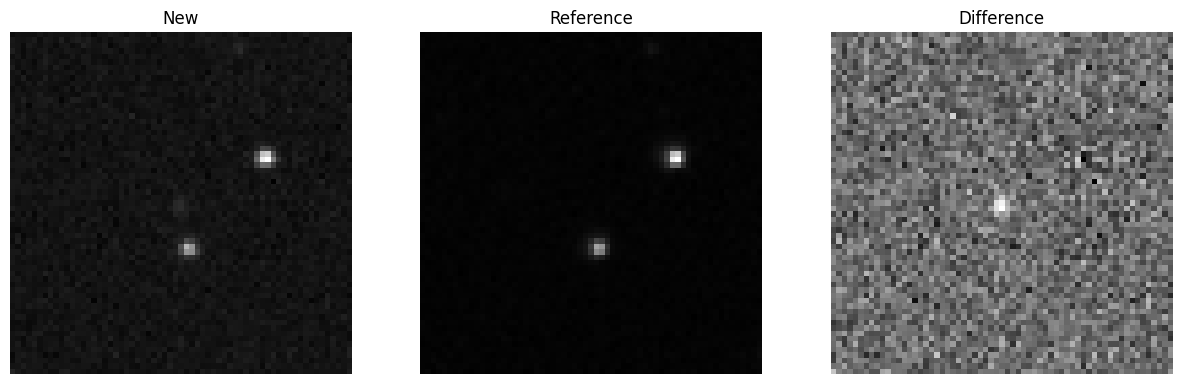

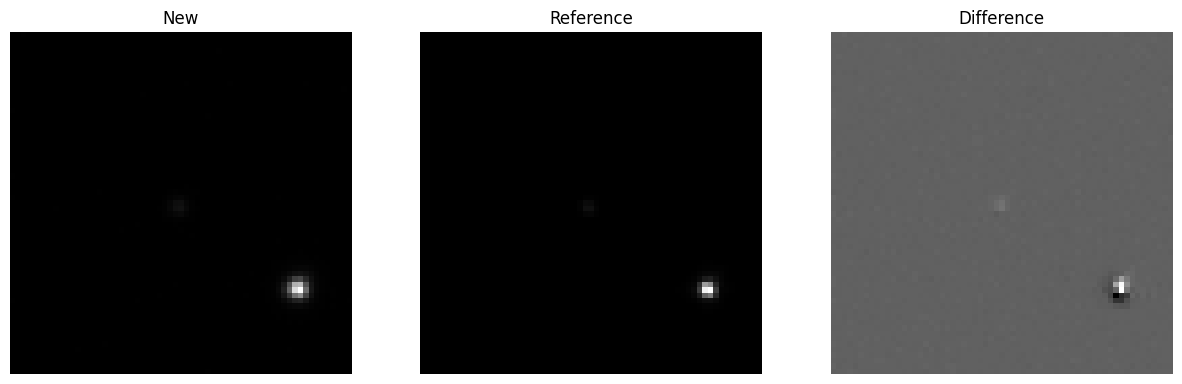

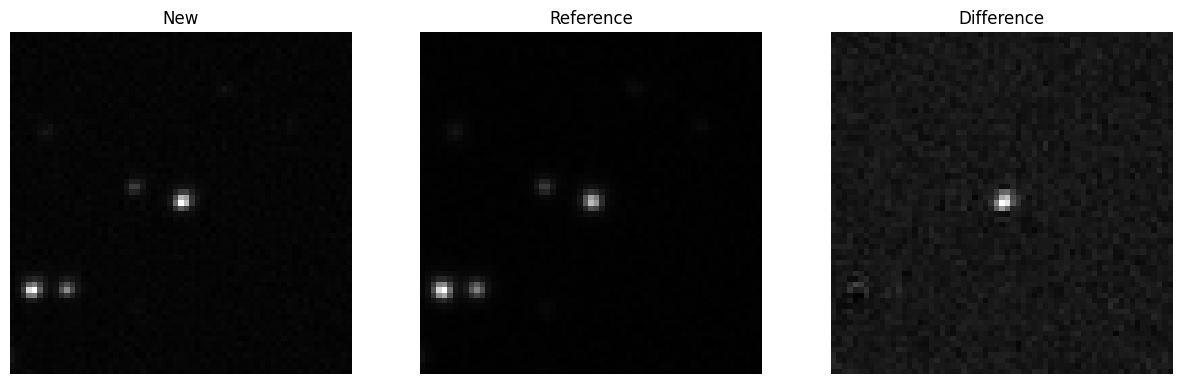

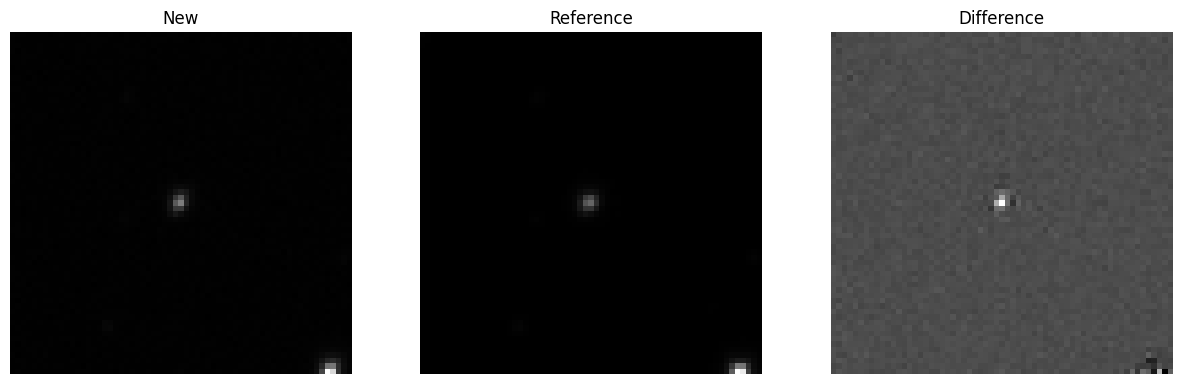

In [ ]:
import numpy as np
import h5py
import matplotlib.pyplot as plt
from pathlib import Path

# Function to plot a single triplet
def plot_triplet(triplet):
    """Plot a triplet of images."""
    fig, axs = plt.subplots(1, 3, figsize=(15, 5))
    titles = ['New', 'Reference', 'Difference']
    for i, img in enumerate(triplet):
        axs[i].imshow(img, cmap='gray', origin='lower')
        axs[i].title.set_text(titles[i])
        axs[i].axis('off')
    plt.show()

# Example usage
all_image_paths = [str(path) for path in Path(h5_folder_path).glob('*.h5')]

# Choose a subset of files for demonstration
sample_paths = all_image_paths[:6]  # Adjust as needed

for file_path in sample_paths:
    with h5py.File(file_path, 'r') as hf:
        images = hf['images'][:]  # Assuming 'images' dataset shape is (N, 3, height, width)

        # Select and plot the first triplet from each file for demonstration
        img1, img2, diff_img = images[0]  # Extract the first triplet
        img1_nan_to_num = np.nan_to_num(img1, nan=0.0)
        img2_nan_to_num = np.nan_to_num(img2, nan=0.0)
        diff_img_nan_to_num = np.nan_to_num(diff_img, nan=0.0)

        plot_triplet([img1_nan_to_num, img2_nan_to_num, diff_img_nan_to_num])


## Suggested steps to follow

- Decide how to preprocess the inputs images.
- Decide which kind of network
- Decide on how to perform the clustering (Bottleneck latent space? Directly unsupervised clustering of images?)

# Example of preprocessing and simple network with Tensorflow

In [ ]:
from skimage.exposure import rescale_intensity
import numpy as np
import h5py

# Function to normalize a single image based on its 2nd and 98th percentiles
def normalize_image(image):
    p2, p98 = np.percentile(image, (2, 98))
    image_rescaled = rescale_intensity(image, in_range=(p2, p98))
    return image_rescaled

# Function to crop the image in the center
def crop_center(img, cropx, cropy):
    y, x = img.shape
    startx = x // 2 - (cropx // 2)
    starty = y // 2 - (cropy // 2)
    return img[starty:starty + cropy, startx:startx + cropx]

# Simplified image generator that processes images individually
def image_generator(image_paths, batch_size):
    """Yield batches of input images (concatenated img1 and img2) and their corresponding output images (diff_img)."""
    for file_path in image_paths:
        with h5py.File(file_path, 'r') as hf:
            images = hf['images'][:]  # Assuming 'images' dataset shape is (N, 3, height, width)

        # Process each triplet in the file
        for start_idx in range(0, images.shape[0], batch_size):
            end_idx = min(start_idx + batch_size, images.shape[0])
            batch_triplets = images[start_idx:end_idx]

            batch_inputs = []
            batch_outputs = []
            for triplet in batch_triplets:
                img1, img2, diff_img = [np.nan_to_num(img, nan=0.0) for img in triplet]

                # Normalize and crop each image independently
                img1_processed = crop_center(normalize_image(img1), 48, 48).reshape(48, 48, 1)
                img2_processed = crop_center(normalize_image(img2), 48, 48).reshape(48, 48, 1)
                diff_img_processed = crop_center(normalize_image(diff_img), 48, 48).reshape(48, 48, 1)

                # For autoencoder, input is concatenated img1 and img2, and output is diff_img
                input_images = np.concatenate([img1_processed, img2_processed], axis=-1)
                batch_inputs.append(input_images)
                batch_outputs.append(diff_img_processed)

            yield np.array(batch_inputs), np.array(batch_outputs)

# Assume train_paths and val_paths are defined as lists of image paths
import tensorflow as tf

def get_dataset(image_paths, batch_size=32, is_training=True):
    dataset = tf.data.Dataset.from_generator(
        lambda: image_generator(image_paths, batch_size),
        output_signature=(
            tf.TensorSpec(shape=(None, 48, 48, 2), dtype=tf.float32),
            tf.TensorSpec(shape=(None, 48, 48, 1), dtype=tf.float32)
        )
    )
    if is_training:
        dataset = dataset.shuffle(buffer_size=256).repeat()
    else:
        dataset = dataset.repeat()
    dataset = dataset.prefetch(buffer_size=tf.data.AUTOTUNE)
    return dataset


from sklearn.model_selection import train_test_split

# Then split these filtered paths into train, validation, and test sets
train_paths, test_val_paths = train_test_split(all_image_paths, test_size=0.3)
val_paths, test_paths = train_test_split(test_val_paths, test_size=0.5)


# Example on how to use get_dataset
train_dataset = get_dataset(train_paths, batch_size=32, is_training=True)
val_dataset = get_dataset(val_paths, batch_size=32, is_training=False)

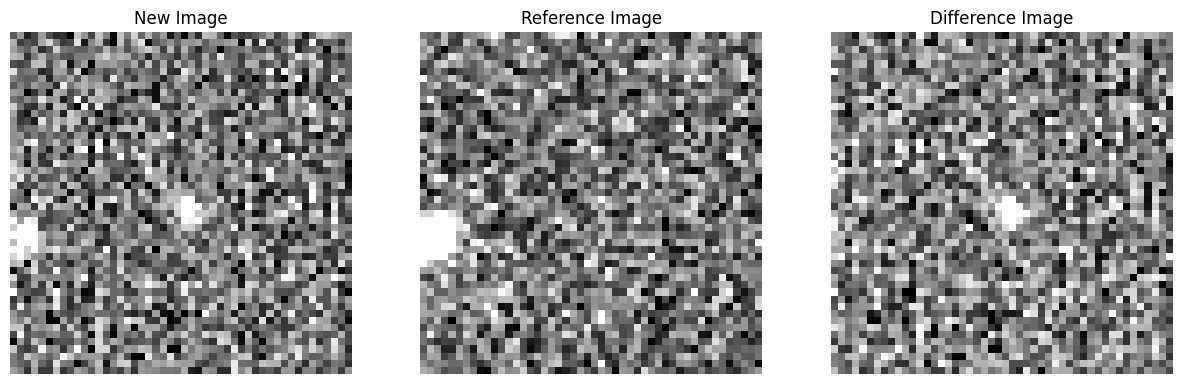

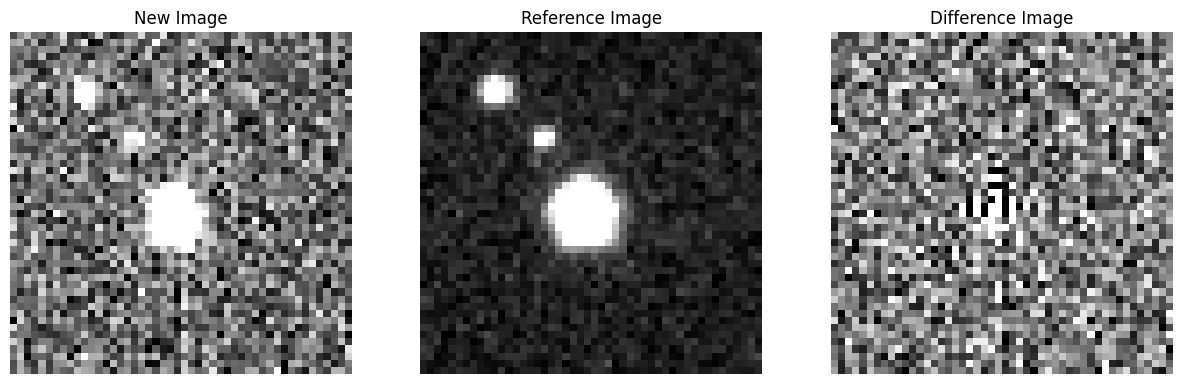

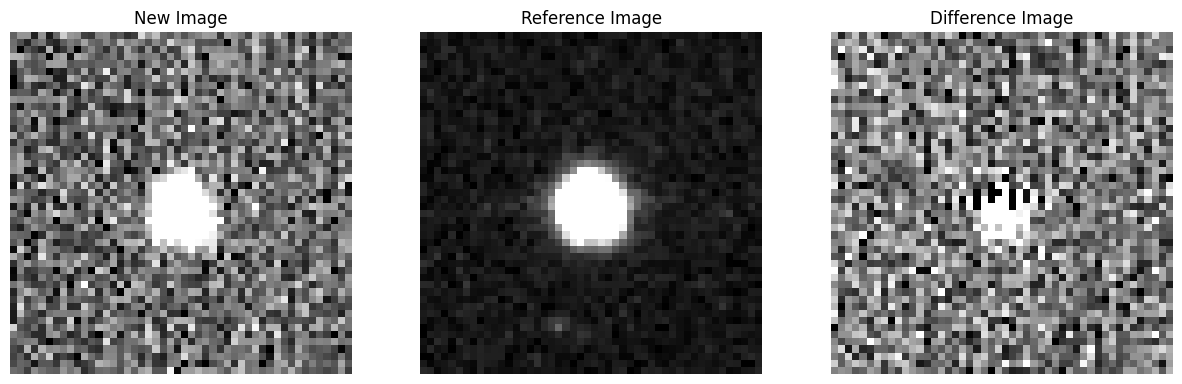

In [ ]:
import matplotlib.pyplot as plt

# Function to visualize triplets from the dataset
def visualize_triplets(dataset, num_triplets=3):
    for input_images, output_images in dataset.take(1):  # Taking 1 batch
        for i in range(min(num_triplets, input_images.shape[0])):  # Visualizing the first few triplets
            fig, axs = plt.subplots(1, 3, figsize=(15, 5))

            # Input Image 1
            axs[0].imshow(input_images[i, :, :, 0], cmap='gray')
            axs[0].title.set_text("New Image")
            axs[0].axis("off")

            # Input Image 2
            axs[1].imshow(input_images[i, :, :, 1], cmap='gray')
            axs[1].title.set_text("Reference Image")
            axs[1].axis("off")

            # Output Image (Difference Image)
            axs[2].imshow(output_images[i, :, :, 0], cmap='gray')
            axs[2].title.set_text("Difference Image")
            axs[2].axis("off")

            plt.show()

# Visualize triplets from the training dataset
visualize_triplets(train_dataset, num_triplets=3)


## You can find many great examples of autoencoder in the [Keras Blog](https://blog.keras.io/building-autoencoders-in-keras.html) and everywhere online!


# Start your NETWORK HERE...
